# PoC - STACKED PERIODOGRAM CALCULATION

This notebook is the PoC to calculate a stacked periodogram of all the valid files contained in a specified folder.

- Input data:
  - The folder containing the input files is specified upon instance initialization.
  - Input files are expected to be simple text files with at least two columns: x (frequency) and y (power).
  - An identifier for the study can be specified with the paremeter `case_name`. This identifier will be included as part of the name of the result files.
  - Headers maybe present in the input files, if identified by a special character ('#' by default, specified by parameter `comments`).
  - File separator is also configurable in the instance initialization (parameter `sep`). By default it is set to the blank space (' ').
  - The decimal point must be the dot ('.').
  - **Important assumption:** all the input files must share exactly the same x-axis values (frequency). The first file successfully read determines the frequency axis for the stacked periodograms. Later files which do not conform strictly to this frequency axis will be discarded.

- Upon initialization, the following operations are carried out:
  - The `StackedPg` instance reads all the files in the folder specified in the instance initialization. Each one is expected to be a single object periodogram.
  - Each individual periodogram is normalized to a total power value (area under the curve) of 1.0.
  - The individual periodograms are stacked in `AND` form (multiplication of power values) and in `OR`form (addition of power values).
  - Those files under the folder that cannot be read or incorporated are stored in a class attribute `error_files`, along with the system error yielded.
  - The resulting `AND` and `OR` periodograms are again normalized to a total power of 1.0. Along with the frequency axis,  they are stored as a numpy array in the `stacked` attribute.

- The resulting periodograms can be:
  - Plotted (and the resulting plot saved to a '.jpg' file), using the class method `plot`.
  - Saved to a plain '.dat' file, using the class method `save`.

- Possible improvements include:
  - We leave open the option to have a potential third column for FAP values (or even more columns for other consideration). Files should be comma separated, with the '.' as decimal point.
  - A non-homogeneous frequency-axis among the individual periodograms under the folder could be envisaged.


## Modules and configuration

### Modules

In [69]:
import os

import numpy as np

from matplotlib import pyplot as plt

### Configuration

In [70]:
# EXAMPLE FILE:
DATA_FOLDER = "../data/STACKED_PG/TEST_1/" # Working data folder
#DATA_FOLDER = "./PG_subsample_TESS_StackedPG/" # Working data folder

### Class definition

In [84]:
class StackedPg:
    """Generates a stacked periodogram objects from the files existing in a 'folder' passed
    at initialization.
    The files in the folder must be plain files of individual periodograms, with at least two columns:
    - frequency
    - power
    Any file that cannot be decoded / incorporated will be ignored (and reported)
    
    Parameters
    ----------
    - folder: (mandatory) the work folder holding the individual periodograms.
    - case_name: (optional) an identifier for identifying the case (it will be included in the names of the
        result files).
    - sep: the spacing character in the individual periodogram files.
    - comments: the character that identifies a comment in both the individual periodogram files and in the
    result file.
    - ref_lines: a list of tuples to configure reference vertical lines to ber shown in the plot. Each tuple in
    the list is composed of the frequency value where the line should be drawn, and a string with an identifier
    of the line (use 'None' in the second item in the tuple if you want that particular reference line to be
    omitted from the legend).
    - ref_colors: a list containing the colors for reference lines.
    - ref_styles: a list containing the styles for reference lines.
    Note: defaults are provided for 'colors' and 'styles' if not specified.
    
    Attributes
    ----------
    - folder: the work folder holding the individual periodograms.
    - case_name: (optional) a string identifying the case under analysis. It is also used for file names
    - stacked: the numpy array containing the normalized stacked periodogram, with three columns:
        - frecs
        - AND (multiplication)
        - OR (addition)
    - error_files: a list of the files under which could not be incorporated into the stacked periodogram.
        
    Methods
    -------
    - _calcStacked: calculates the stacked periodograms (called upon instance initialization).
    - plot: plots the calculated stacked periodograms and (optionally) saves them to a file.
    - save: saves the stacked periodograms into a text file.
    """
    
    def __init__(self, folder, case_name=None, header=False, sep=' ', comments="#", ref_lines=[],
                 ref_colors=None, ref_styles=None):
        self.folder = folder
        if case_name is None:
            self.case_name = self.folder
        else:
            self.case_name = case_name
        self.header=header
        self.sep = sep
        self.comments = comments
        self.ref_lines = ref_lines
        if ref_colors is None:
            self.ref_colors = ['red', 'blue', 'green', 'orange']
        else:
            self.ref_colors = ref_colors
        if ref_styles is None:
            self.ref_styles = ['-', '--', '-.', ':']
        else:
            self.ref_styles = ref_styles
        self.error_files = []
        self.stacked = None
        self._calcStacked()
        #self.stacked_and = None
        #self.stacked_or = None
    
    def _calcStacked(self):
        """ Calculates both stacked periodograms: AND and OR"""
        #pg_files = os.listdir(self.folder)
        pg_files = [f for f in os.listdir(self.folder) if os.path.isfile(self.folder + f)]
        frecs = None
        stacked_and = None
        stacked_or = None
        for f in pg_files:
            #if True: # TEST
            try:
                new_pg = np.genfromtxt(self.folder + f, comments=self.comments, delimiter=self.sep)
                # Normalize individual PG:
                #new_pg[:, 1] = new_pg[:, 1] / np.sum(new_pg[:, 1])
                new_pg[:, 1] = new_pg[:, 1] / np.trapz(y=new_pg[:, 1], x=new_pg[:, 0])
                if frecs is None:
                    frecs = new_pg[:, 0].copy()
                    stacked_and = new_pg[:, 1].copy()
                    stacked_or = new_pg[:, 1].copy()
                else:
                    stacked_and = stacked_and * new_pg[:, 1]
                    stacked_or = stacked_or + new_pg[:, 1]
            #else: # TEST
            except Exception as e:
                self.error_files.append((f, str(e)))
        # Normalize the stacked periodograms:
        stacked_and = stacked_and / np.trapz(y=stacked_and, x=frecs)
        stacked_or = stacked_or / np.trapz(y=stacked_or, x=frecs)
        #stacked_and = stacked_and / np.sum(stacked_and)
        #stacked_or = stacked_or / np.sum(stacked_or)
        # Construct the array:
        self.stacked = np.vstack((frecs, stacked_and, stacked_or)).T
        
    def plot(self, showfig=True, savefig=False, combined=False):
        """ Plots the resulting stacked periodograms.
        Optionally, the figure can also be saved to a 'jpg' file.
        The parameter 'combined' is used to generate a single plot or a separate plot"""
        if combined == True:
            plt.figure(figsize=(15.0, 5.0))
            plt.plot(self.stacked[:,0], self.stacked[:,1], label="AND operation")
            plt.plot(self.stacked[:,0], self.stacked[:,2], label="OR operation")
            mark_count = 0
            for refline in self.ref_lines:
                c_idx = mark_count % len(self.ref_colors)
                s_idx = mark_count % len(self.ref_styles)
                plt.axvline(x=refline[0],
                            color=self.ref_colors[c_idx], linestyle=self.ref_styles[s_idx],
                            label=refline[1])
                mark_count += 1
            plt.title(self.case_name + " Stacked periodograms", fontdict = {'fontsize' : 20})
            plt.xlabel("Frequency", fontsize=12)
            plt.ylabel("Normalized power", fontsize=12)
            plt.legend()
            if showfig == True:
                plt.show()
            if savefig == True:
                plt.savefig(self.folder + self.case_name + "_StackedPG_Combined.jpg", format='jpg')
        else:
            fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15.0, 10.0))
            fig.suptitle(self.case_name + " Stacked periodograms", fontsize=20)
            axs[0].plot(self.stacked[:,0], self.stacked[:,1])
            axs[0].set_title("AND operation", fontsize = 16)
            axs[0].set_xlabel("Frequency", fontsize = 12)
            axs[0].set_ylabel("Normalized power", fontsize=16)
            mark_count = 0
            for refline in self.ref_lines:
                c_idx = mark_count % len(self.ref_colors)
                s_idx = mark_count % len(self.ref_styles)
                axs[0].axvline(x=refline[0],
                               color=self.ref_colors[c_idx], linestyle=self.ref_styles[s_idx],
                               label=refline[1])
                mark_count += 1
            axs[1].plot(self.stacked[:,0], self.stacked[:,2])
            #axs[1].set_title("OR operation", fontdict = {'fontsize' : 16})
            axs[1].set_title("OR operation", fontsize=16)
            axs[1].set_xlabel("Frequency", fontsize=12)
            axs[1].set_ylabel("Normalized power", fontsize=12)
            mark_count = 0
            for refline in self.ref_lines:
                c_idx = mark_count % len(self.ref_colors)
                s_idx = mark_count % len(self.ref_styles)
                axs[1].axvline(x=refline[0],
                               color=self.ref_colors[c_idx], linestyle=self.ref_styles[s_idx],
                               label=None)
                mark_count += 1
            fig.tight_layout(pad=1.5, h_pad=1.5)
            
            fig.legend()
            
            if showfig == True:
                fig.show()
            if savefig == True:
                plt.savefig(self.folder + self.case_name + "_StackedPG_Separate.jpg", format='jpg')
                
    def save(self, header=True, sep=' '):
        """ Saves the stacked periodograms, a single file with three columns 
        is generated (frecs, AND, OR)"""
        if header == False:
            header_text = ""
        else:
            header_text = "frec" + sep + "AND" + sep + "OR"
        np.savetxt(self.folder + self.case_name + "_StackedPG.dat", self.stacked,
                   fmt='%.9f', delimiter=sep, header=header_text, comments=self.comments)

In [85]:
def area_curve(x, y):
    '''Calculates and returns the area under a discrete curve'''
    return np.trapz(y=y, x=x)

## Test the class:

### Initialization with some incorrect files (not-matching x-axis; wrong type of file)

In [86]:
stpg = StackedPg(folder=DATA_FOLDER, case_name="TEST1", sep='\t',
                 ref_lines=[(7.5, "Ref A"), (20.0, "Ref B")])

Show the results of the stacked periodograms by accessing the instance attribute `stacked` (a `numpy` array).

In [87]:
stpg.stacked

array([[ 3.        ,  0.        ,  0.02844575],
       [ 3.33126271,  0.11892741,  0.08288786],
       [ 3.8821981 ,  0.1094194 ,  0.08288439],
       [ 4.80245449,  0.        ,  0.0247011 ],
       [ 5.09396912,  0.        ,  0.02766087],
       [ 5.6117938 ,  0.        ,  0.02845176],
       [ 6.44481532,  0.        ,  0.02398305],
       [ 6.56437476,  0.        ,  0.0267514 ],
       [ 7.00660192,  0.        ,  0.02346396],
       [ 7.30843548,  0.        ,  0.02602642],
       [ 7.8888649 ,  0.        ,  0.02639437],
       [ 7.93327646,  0.        ,  0.02648648],
       [ 8.47152372,  0.        ,  0.02324642],
       [ 9.17562564,  0.12073113,  0.08793082],
       [ 9.71637053,  0.10601733,  0.08183354],
       [10.05175141,  0.12822159,  0.09029549],
       [10.11746354,  0.        ,  0.02464005],
       [10.65924996,  0.        ,  0.02459394],
       [11.4946377 ,  0.12029595,  0.08476526],
       [12.33005485,  0.11906111,  0.08457285],
       [12.41527218,  0.        ,  0.023

The frecquency list can be accessed like this:

In [88]:
stpg.stacked[:, 0]

array([ 3.        ,  3.33126271,  3.8821981 ,  4.80245449,  5.09396912,
        5.6117938 ,  6.44481532,  6.56437476,  7.00660192,  7.30843548,
        7.8888649 ,  7.93327646,  8.47152372,  9.17562564,  9.71637053,
       10.05175141, 10.11746354, 10.65924996, 11.4946377 , 12.33005485,
       12.41527218, 12.44896646, 12.90005321, 13.38608078, 13.97130885,
       14.74110772, 15.71679389, 16.68602912, 16.7442914 , 17.53481194,
       18.11907544, 18.79211209, 19.54876162, 19.93953637, 20.3319619 ,
       21.19545727, 21.19946572, 21.22944238, 22.10114428, 22.41182866])

We check that the area under the stacked periodograms is 1.0 (because they are normalized).

This one is for `AND` stacked periodogram:

In [89]:
area_curve(x=stpg.stacked[:,0], y=stpg.stacked[:,1])

0.9999999999999998

And this one for the `OR`stacked periodogram:

In [90]:
area_curve(x=stpg.stacked[:,0], y=stpg.stacked[:,2])

1.0

The member variable `error_files` contains the files under the folder that could not be incorporated into the stacked periodogram, and the string of the system error that was raised.

In [91]:
stpg.error_files

[('ETL_30_01_Test_LC_PG.fits',
  "'charmap' codec can't decode byte 0x90 in position 934: character maps to <undefined>"),
 ('J00051+457_TESS_PG.png',
  "'charmap' codec can't decode byte 0x9d in position 134: character maps to <undefined>"),
 ('PG_03_MISSING_AXIS_VALUE.txt',
  'operands could not be broadcast together with shapes (40,) (39,) '),
 ('TEST1_StackedPG.dat',
  'too many indices for array: array is 1-dimensional, but 2 were indexed'),
 ('TEST1_StackedPG_Combined.jpg',
  "'charmap' codec can't decode byte 0x81 in position 251: character maps to <undefined>"),
 ('TEST1_StackedPG_Combined.png',
  "'charmap' codec can't decode byte 0x9d in position 137: character maps to <undefined>"),
 ('TEST1_StackedPG_Separate.jpg',
  "'charmap' codec can't decode byte 0x81 in position 251: character maps to <undefined>"),
 ('TEST1_StackedPG_Separate.png',
  "'charmap' codec can't decode byte 0x8f in position 479: character maps to <undefined>")]

### Plot the stacked periodograms

#### Separated periodograms

<ipython-input-84-0b74dd427838>:156: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


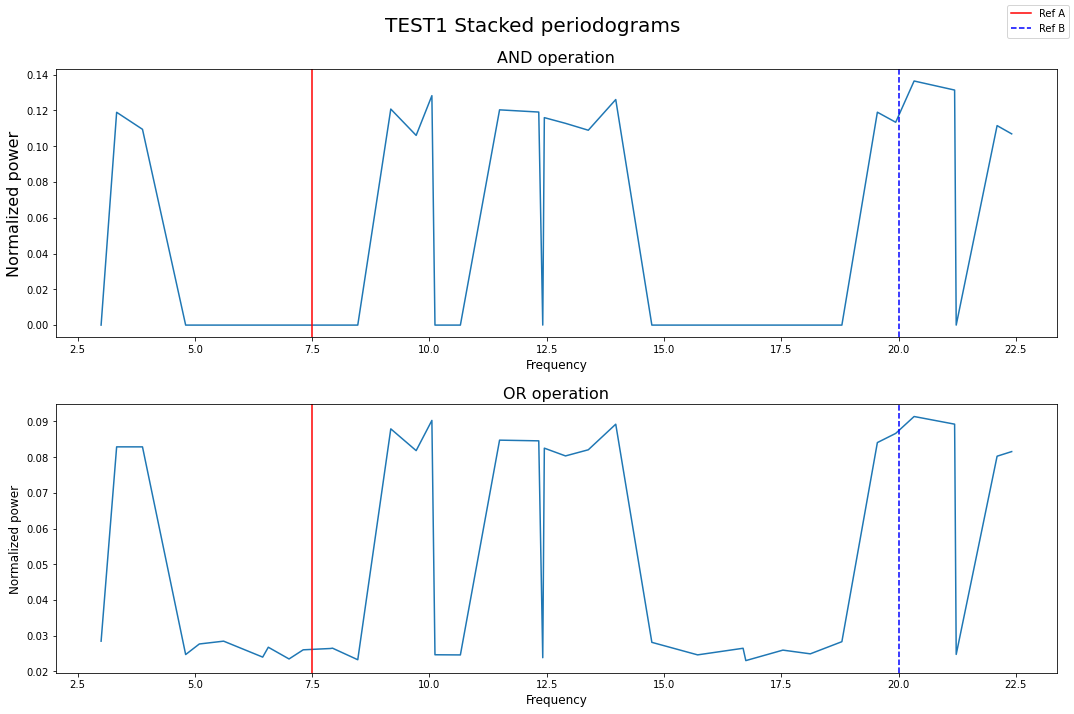

In [92]:
stpg.plot()

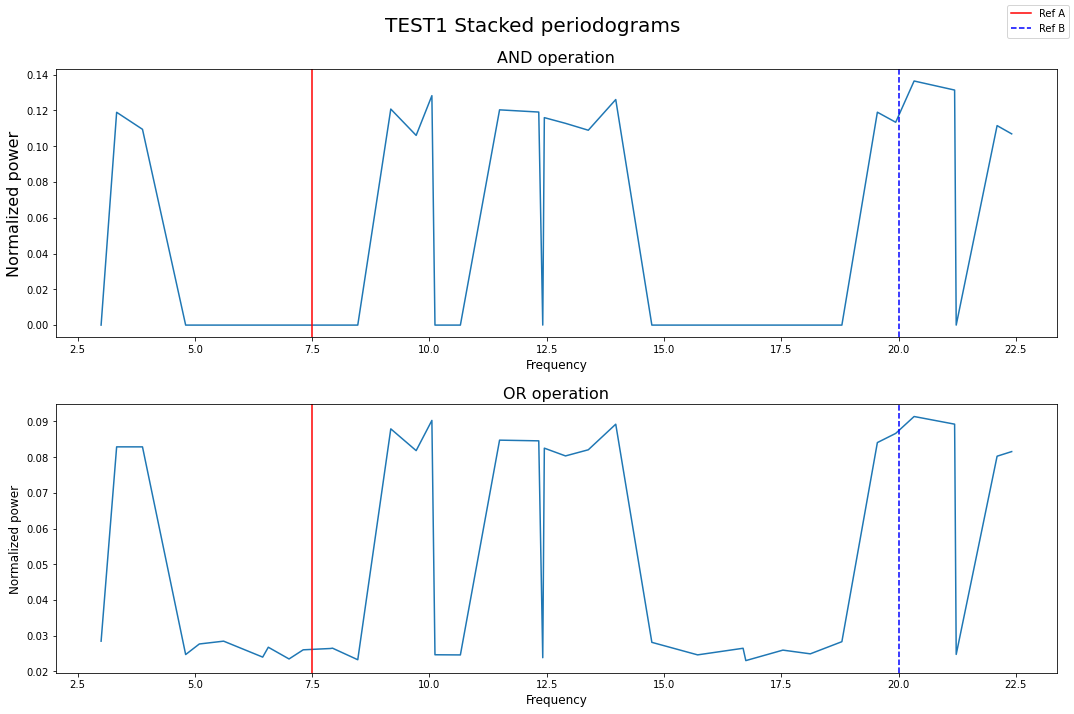

In [93]:
stpg.plot(showfig=False, savefig=True)

Note that the option `showfig=False` seems to have no effect in Jupyter Notebooks: the plot is shown.

#### Combined periodograms

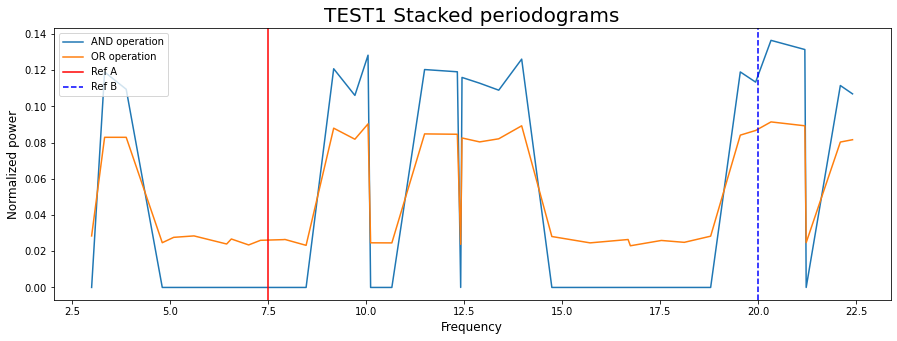

In [94]:
stpg.plot(combined=True)

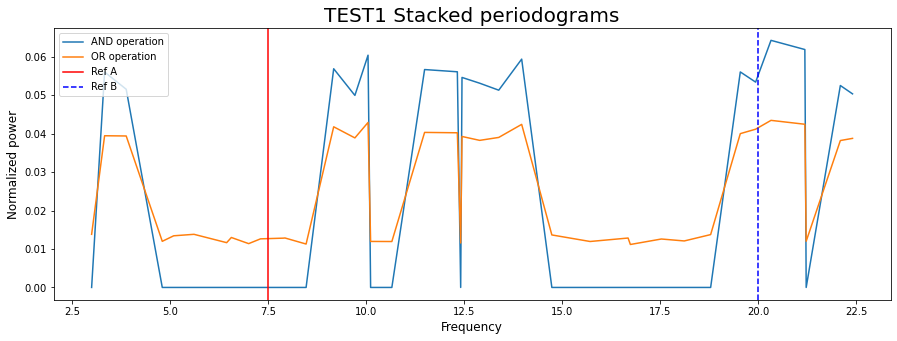

In [81]:
stpg.plot(combined=True)

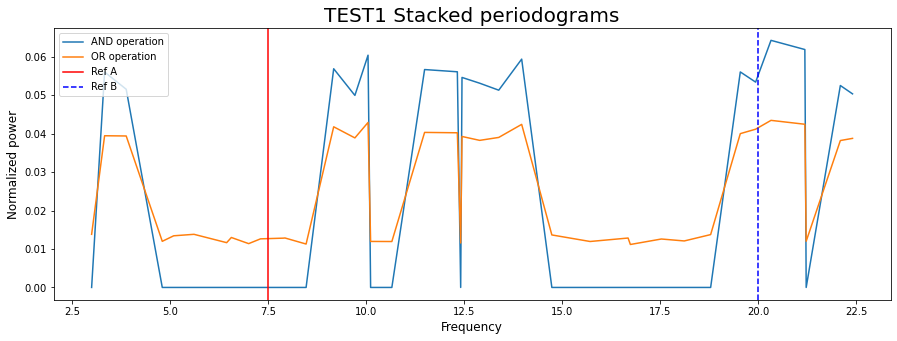

In [82]:
stpg.plot(combined=True, showfig=False, savefig=True)

Note that the option `showfig=False` seems to have no effect in Jupyter Notebooks: the plot is shown.

### Save the periodograms

In [83]:
stpg.save()

## Overriding the line styles

In [21]:
stpg = StackedPg(folder=DATA_FOLDER, case_name="TEST1", sep='\t',
                 ref_lines=[(7.5, "Lower expected pulsation"), (20.0, "Higher expected pulsation")],
                 ref_colors=['red', 'green'], ref_styles=['--', ':'])

<ipython-input-8-0d02e9247d50>:152: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


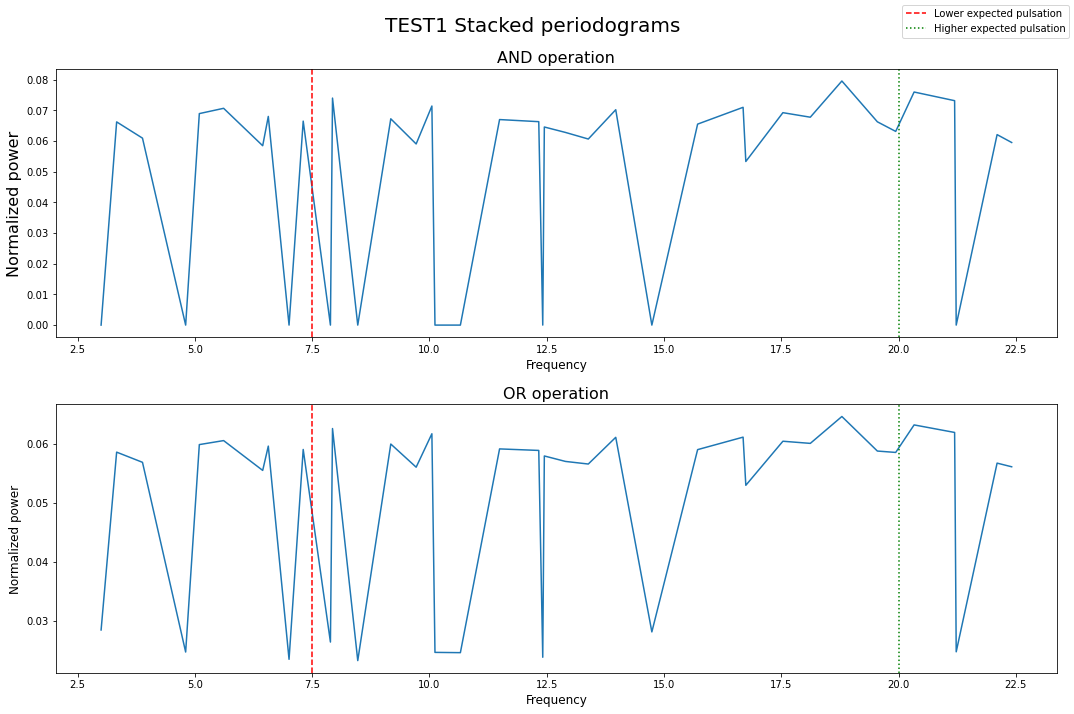

In [22]:
stpg.plot()

# Summary

**OBSERVATIONS AND CONCLUSIONS:**
- We created and tested the stacked periodogram class to calculate, plot and save stacked periodograms.